# Experimental FFN model
use the KPIs we discussed previously alongside the new item statistics to train a basic pytorch model

### imports

In [46]:
# Imports
from tqdm import tqdm
import glob
import os
import sys
import numpy as np
import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torcheval.metrics import MulticlassAccuracy
from torchmetrics.classification import MulticlassJaccardIndex

sys.path.append(os.path.join("..", "..", "src"))
from game_data_collector.api import Role, get_hero_ids_of_role

## data extraction

you can skip this part and load the prebuilt dataset `player_data.csv.bz2` instead

In [34]:
# only consider CC heroes when building the dataframe
CC_ONLY: bool = False

# aggregate to rank groups 10, 20, ... instead of 11, ..., 15, 21, ..., 25 for simplification ?
AGGREGATE_RANKS: bool = True

### load data

In [3]:
# Building the data frame from the raw data
# TODO I'm skipping the database integration for now (query building etc.) to cut some time for faster EDA

json_files = list(glob.iglob("C:\\Users\\cedri\\dota-project\\mmr-predictor\\resources\\data\\*.json"))
print(f"found {len(json_files):,} match dumps")

found 22,641 match dumps


In [4]:
# limit on CC class?
if CC_ONLY:
    ROLE = Role.CANONICAL_CARRY

    cc_ids: list = get_hero_ids_of_role(ROLE)
    print(f"got {len(cc_ids)} distinct hero ids for Role '{ROLE.name}'")

In [7]:
# item uses
# Get all distinct items from the data for the cols
distinct_items = set()

# 31s
for j in tqdm(json_files, total=len(json_files)):
    with open(j, "r", encoding="utf-8") as fi:
        match = json.load(fi)
        for player in match["players"]:
            
            # filter hero class
            if CC_ONLY and player["hero_id"] not in cc_ids:
                continue
    
            # Combine item uses and purchases into one loop
            distinct_items.update(player["item_uses"].keys())
            distinct_items.update(player["purchase"].keys())

print(f"found {len(distinct_items):,} distinct items in the data")
# print("\n".join([d for d in distinct_items]))

distinct_items_only = [i for i in distinct_items if "recipe" not in i]
print(f"found {len(distinct_items_only):,} items without recipes")

NameError: name 'json_files' is not defined

### built dataframe from json dumps

In [6]:
# aggregate to rank groups 10, 20, ... instead of 11, ..., 15, 21, ..., 25 for simplification ?
AGGREGATE_RANKS: bool = False

In [7]:
# define columns
# cols = ["rank_tier", "hero_kills", "deaths", "denies", "hero_damage", "actions_per_min", "gold_per_min", "xp_per_min", "lane_efficiency_pct", "lane_kills", "last_hits", "tower_damage", "win"] + list(distinct_items_only)

skip_stat = ["account_id", "benchmarks", "hero_id", "is_roaming", "kill_streaks", "lane_efficiency_pct", "life_state", "multi_kills", "neutral_item_history", "neutral_tokens_log", "obs", "obs_left_log", "obs_log", "purchase", "rank_tier", "runes", "sen", "sen_left_log", "sen_log", "item_uses"]

cols = ["rank_tier", "hero_id"]

with open(json_files[0], "r", encoding="utf-8") as fi:
    match = json.load(fi)
            
    for s in match["players"][0]:
        if s not in skip_stat:
            cols.append(s)
            
cols = cols + list(distinct_items_only)
            
print(f"total of {len(cols)-1} predictor vars (item_uses starts at idx {len(cols)-len(distinct_items_only)})")

total of 280 predictor vars (item_uses starts at idx 55)


In [ ]:
# fill df with common stats and combine with item uses

data_rows = []

# 35s
for j in tqdm(json_files, total=len(json_files)):
    with open(j, "r", encoding="utf-8") as fi:
        match = json.load(fi)
                
        for player in match["players"]:
            
            # filter hero class
            if CC_ONLY and player["hero_id"] not in cc_ids:
                continue
                        
            # filter players not in rank tier interval (0, 80)
            if (player["rank_tier"] == None) or (player["rank_tier"] == 80):
                continue


                        
            # Initialize a dictionary for the current row
            row_data = {col: 0 for col in cols}  # Set default counts to 0
            
            # match level stats
            row_data["duration"] = match["duration"]            
            
            # player stats
            for stat in player.keys():
                if stat in cols:
                    row_data[stat] = player[stat]

            # Update counts based on the player's item uses and purchases
            for item, count in player["item_uses"].items():
                if item in row_data:
                    row_data[item] += count
        
            data_rows.append(row_data)

df = pd.DataFrame(data_rows)

print(f"df with {len(df):,} players' data") # note that 10 player per match = match count times 10

100%|██████████| 22641/22641 [00:43<00:00, 518.90it/s]


df with 92,691 players' data


In [9]:
print(df.sample(n=5))

      rank_tier  hero_id  player_slot  obs_placed  sen_placed  creeps_stacked  \
77654        45       44          130           0           0               0   
36356        61      111          129           8          12               0   
87322        61      138          129           4           6               3   
14051        33       41            1           0           1               0   
77225        42       20          128           6           7               2   

       camps_stacked  rune_pickups  teamfight_participation  observers_placed  \
77654              0             1                 0.583333                 0   
36356              0             5                 0.529412                 8   
87322              1             2                 0.444444                 4   
14051              0             6                 0.409091                 0   
77225              1             2                 0.615385                 6   

       ...  ward_dispenser

In [ ]:
# save dataframe?
# df.to_csv(os.path.join("..", "..", "resources", "data", "player_data.csv.bz2"), header=True, compression='bz2')

# # load dataframe?
# df = pd.read_csv(os.path.join("..", "..", "resources", "data", "player_data.csv.bz2"), index_col=0)
# print(df.head())

   rank_tier  hero_id  player_slot  obs_placed  sen_placed  creeps_stacked  \
0         55       64            0           8          11               4   
1         61      123            4           1           0               0   
2         61       36          130           2           2               3   
3         43       58            0           0           0               0   
4         63       32            1           8          17               4   

   camps_stacked  rune_pickups  teamfight_participation  observers_placed  \
0              2             0                 0.657143                 8   
1              0            10                 0.342857                 1   
2              1             3                 0.666667                 2   
3              0             2                 0.695652                 0   
4              1             4                 0.695652                 8   

   ...  ward_dispenser  javelin  invis_sword  aeon_disk  mana_draugh

In [48]:
if AGGREGATE_RANKS:
    # simplification
    df["rank_tier"] = (df["rank_tier"] // 10).astype("category")
else:
    # target var should be categorical
    df["rank_tier"] = df["rank_tier"].astype("category")

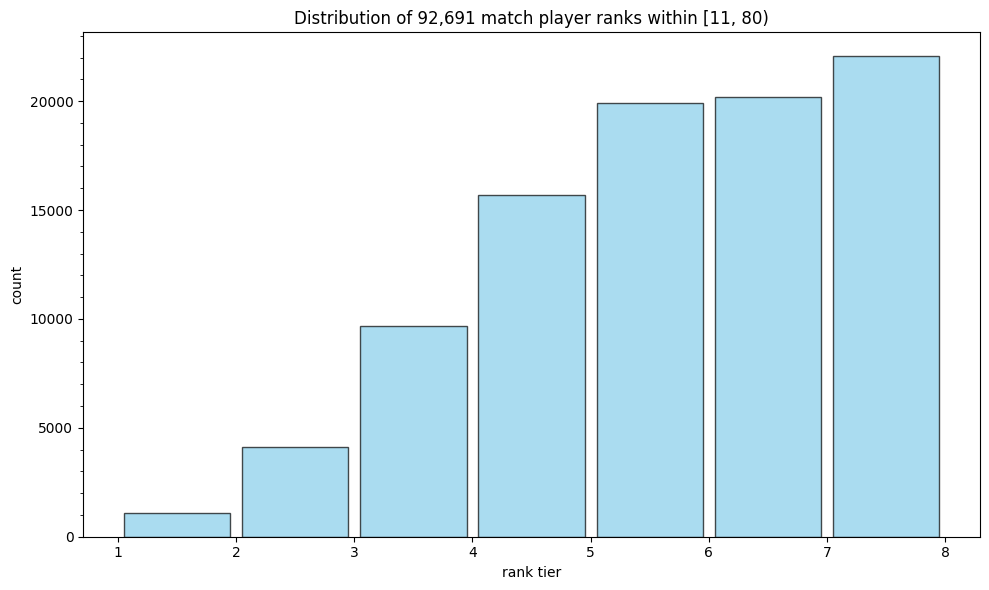

In [49]:
# Create the histogram
plt.figure(figsize=(10, 6))

if AGGREGATE_RANKS:
    bins = range(1, 9, 1)
else:
    bins = range(11, 91, 10)  # Bins from 0 to 80 with a width of 10
bar_width = 0.9 * (bins[1] - bins[0]) 

# Plot histogram
counts, _, patches = plt.hist(data=df, x="rank_tier", bins=bins, density=False, edgecolor='black', color='skyblue', alpha=0.7, rwidth=0.9)

# Labeling x and y axis, and title
plt.xlabel('rank tier')
plt.ylabel('count',)
plt.title(f'Distribution of {len(df):,} match player ranks within [11, 80)')

if AGGREGATE_RANKS:
    plt.xticks(range(1, 9, 1))
else:
    # Set x-ticks at intervals of 10
    plt.xticks(range(11, 91, 10))

# minor ticks
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', left=True)
plt.tick_params(axis='x', which='minor', bottom=False)


# Display counts on top of each bar
# for count, patch in zip(counts, patches):
#     height = patch.get_height()
#     plt.text(patch.get_x() + patch.get_width() / 2, height + 150, f'{int(count)}', ha='center')

# Show the plot
plt.tight_layout()
plt.show()

## neural network

### splits and target variable rebalancing

In [50]:
# X: numpy array (n_samples × n_features)
# y: numpy array of integer levels (e.g. [1, 2, 3, …, 79], but only observed classes)
y = df.iloc[:, 0].to_numpy(dtype=np.int64)        # shape (n_samples,)
X = df.iloc[:, 2:].to_numpy(dtype=np.float32)     # shape (n_samples, n_features)

# if using the full rank tier set to create a consistant labeling
# Map original levels to 0…(C-1)
unique_levels = np.sort(np.unique(y))
level_to_idx = {lvl: idx for idx, lvl in enumerate(unique_levels)}

# required for stratification of the imbalanced target classes (see diagram above)
y_idx = np.array([level_to_idx[l] for l in y], dtype=np.int64)
num_classes = len(unique_levels)

for k, v in level_to_idx.items():
    print(f"{k} -> {v}")

1 -> 0
2 -> 1
3 -> 2
4 -> 3
5 -> 4
6 -> 5
7 -> 6


In [51]:
# Train/test split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y_idx,
    test_size=0.2,
    random_state=42,
    # stratify=y_idx
)

In [52]:
# Convert to tensors & datasets
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
y_val_t   = torch.tensor(y_val,   dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=128)

In [53]:
# Compute class weights inversely proportional to frequency
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

### model

In [ ]:
# base model
# model = nn.Sequential(
#     nn.Linear(X.shape[1], 512),
#     nn.BatchNorm1d(512),
#     nn.ReLU(),
#     nn.Dropout(0.2),

#     nn.Linear(512, 256),
#     nn.BatchNorm1d(256),
#     nn.ReLU(),
#     nn.Dropout(0.2),

#     nn.Linear(256, 128),
#     nn.BatchNorm1d(128),
#     nn.ReLU(),
#     nn.Linear(128, num_classes)
# )

model = nn.Sequential(
    nn.Linear(X.shape[1], 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),

    nn.Linear(64, num_classes)
)


In [55]:
# Instantiate metrics
train_acc_metric = MulticlassAccuracy(num_classes=num_classes)
val_acc_metric   = MulticlassAccuracy(num_classes=num_classes)
# val_jaccard      = MulticlassJaccardIndex(num_classes=num_classes, average='macro')

### train loop

In [56]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")
model.to(device)
class_weights = class_weights.to(device)

Using cuda device


In [57]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)

In [58]:
NUM_EPOCHS: int = 100

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []
best_val_acc = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    # Training
    model.train()
    train_acc_metric.reset()
    epoch_train_loss = 0.0
    total_train_samples = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        # forward pass
        optimizer.zero_grad()
        logits = model(xb)
        
        loss = criterion(logits, yb)
        
        # backward pass
        loss.backward()
        optimizer.step()
        
        batch_size = xb.size(0)
        epoch_train_loss += loss.item() * batch_size
        total_train_samples += batch_size

        preds = logits.argmax(dim=1)
        train_acc_metric.update(preds, yb)

    train_loss = epoch_train_loss / total_train_samples
    train_loss_list.append(train_loss)

    train_acc = train_acc_metric.compute().item()
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    val_acc_metric.reset()
    epoch_val_loss = 0.0
    total_val_samples = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            batch_size = xb.size(0)
            epoch_val_loss += loss.item() * batch_size
            total_val_samples += batch_size

            preds = logits.argmax(dim=1)
            val_acc_metric.update(preds, yb)

    val_loss = epoch_val_loss / total_val_samples
    val_loss_list.append(val_loss)

    val_acc = val_acc_metric.compute().item()
    val_acc_list.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc

    if epoch % 10 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:03d}: "
            f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f} | "
            f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}"
        )

print("------------------------------------")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

Epoch 001: Train Loss = 1.9424, Train Acc = 0.1511 | Val Loss = 1.9177, Val Acc = 0.1957
Epoch 010: Train Loss = 1.8668, Train Acc = 0.1957 | Val Loss = 1.8951, Val Acc = 0.1361
Epoch 020: Train Loss = 1.8418, Train Acc = 0.2159 | Val Loss = 1.8433, Val Acc = 0.2234
Epoch 030: Train Loss = 1.8266, Train Acc = 0.2148 | Val Loss = 1.8534, Val Acc = 0.1767
Epoch 040: Train Loss = 1.8221, Train Acc = 0.2211 | Val Loss = 1.8429, Val Acc = 0.2506
Epoch 050: Train Loss = 1.8105, Train Acc = 0.2223 | Val Loss = 1.8162, Val Acc = 0.2089
Epoch 060: Train Loss = 1.8062, Train Acc = 0.2253 | Val Loss = 1.9047, Val Acc = 0.1408
Epoch 070: Train Loss = 1.7940, Train Acc = 0.2257 | Val Loss = 1.8283, Val Acc = 0.1830
Epoch 080: Train Loss = 1.7895, Train Acc = 0.2246 | Val Loss = 1.8403, Val Acc = 0.2473
Epoch 090: Train Loss = 1.7813, Train Acc = 0.2244 | Val Loss = 1.8421, Val Acc = 0.2316
Epoch 100: Train Loss = 1.7744, Train Acc = 0.2234 | Val Loss = 1.8466, Val Acc = 0.1747
---------------------

### evaluation

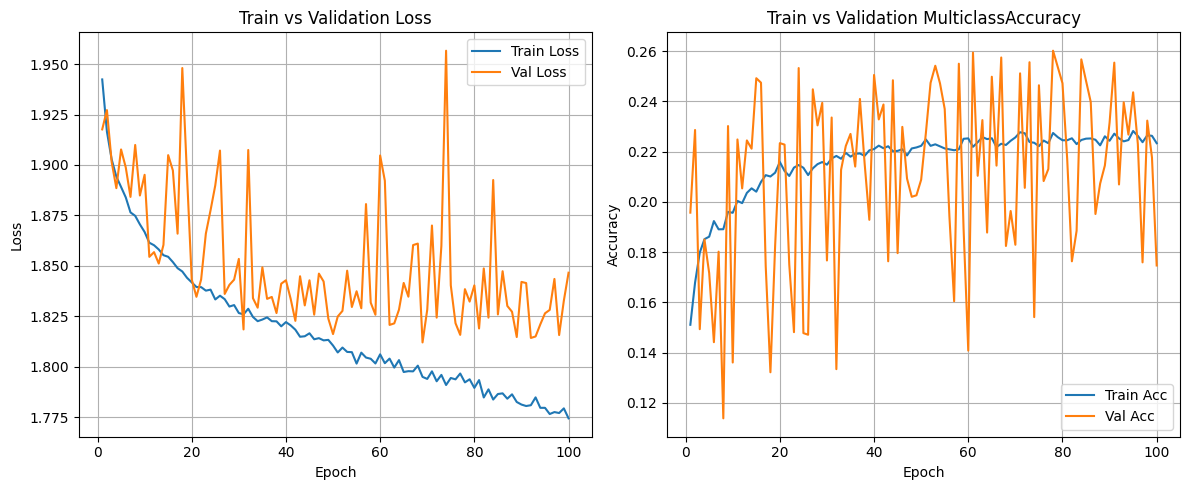

In [59]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_list, label='Train Acc')
plt.plot(epochs, val_acc_list,   label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation MulticlassAccuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## will more data help? ##

In [50]:
class SimpleFFN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleFFN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.output = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.output(x)
        return x

### splits and target variable rebalancing

In [41]:
def run_fold(X, y_idx, train_idx, val_idx, model_cls, batch_size, num_epochs, device):
    # Split data
    X_train, y_train = X[train_idx], y_idx[train_idx]
    X_val,   y_val   = X[val_idx],   y_idx[val_idx]

    # Create tensors & datasets
    train_ds = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.long)
    )
    val_ds = TensorDataset(
        torch.tensor(X_val, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.long)
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size)

    # Compute class weights
    num_classes = len(np.unique(y_idx))
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.arange(num_classes),
        y=y_train
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    # Prepare model, criterion, optimizer, metrics
    model = model_cls(input_dim=X.shape[1], num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
    train_acc_metric = MulticlassAccuracy(num_classes=num_classes).to(device)
    val_acc_metric   = MulticlassAccuracy(num_classes=num_classes).to(device)

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc' : [], 'val_acc' : []
    }

    # Training loop
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_acc_metric.reset()
        total_train_loss = 0.0
        total_train_samples = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            bsize = xb.size(0)
            total_train_loss += loss.item() * bsize
            total_train_samples += bsize
            preds = logits.argmax(dim=1)
            train_acc_metric.update(preds, yb)

        train_loss = total_train_loss / total_train_samples
        train_acc  = train_acc_metric.compute().item()
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        model.eval()
        val_acc_metric.reset()
        total_val_loss = 0.0
        total_val_samples = 0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                bsize = xb.size(0)
                total_val_loss += loss.item() * bsize
                total_val_samples += bsize
                preds = logits.argmax(dim=1)
                val_acc_metric.update(preds, yb)

        val_loss = total_val_loss / total_val_samples
        val_acc  = val_acc_metric.compute().item()
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Optional: print progress
        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
                  f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

In [42]:
def cross_validate(df: pd.DataFrame,
                   model_cls,
                   n_splits: int = 5,
                   batch_size: int = 128,
                   num_epochs: int = 100):
    # Extract features and labels
    y = df.iloc[:, 0].to_numpy(dtype=np.int64)
    X = df.iloc[:, 2:].to_numpy(dtype=np.float32)

    # Map labels to 0..C-1
    unique_levels = np.sort(np.unique(y))
    level_to_idx = {lvl: idx for idx, lvl in enumerate(unique_levels)}
    y_idx = np.array([level_to_idx[l] for l in y], dtype=np.int64)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    fold_results = {}
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_idx), 1):
        print(f"\nStarting fold {fold}/{n_splits}")
        history = run_fold(X, y_idx, train_idx, val_idx,
                           model_cls, batch_size, num_epochs, device)
        fold_results[f'fold_{fold}'] = history

    return fold_results

In [69]:
### without scaling ####

In [ ]:
results_per_df_coverage_without_scaling = {}

coverage = [0.1, 0.25, 0.5, 0.75, 1]

for i in coverage:
    # Randomly sample i fraction of the dataframe
    sub_df = df.sample(frac=i, random_state=42)  # random_state for reproducibility
    print(f"len sub_df: {len(sub_df)}")
    
    results_per_df_coverage_without_scaling[i] = cv_res = cross_validate(sub_df, SimpleFFN)


len sub_df: 927

Starting fold 1/5
Epoch   1 | Train Loss: 2.0232, Train Acc: 0.1876 | Val Loss: 2.0420, Val Acc: 0.2151
Epoch  10 | Train Loss: 1.7565, Train Acc: 0.2024 | Val Loss: 2.2004, Val Acc: 0.1022
Epoch  20 | Train Loss: 1.6095, Train Acc: 0.2591 | Val Loss: 2.0687, Val Acc: 0.1505
Epoch  30 | Train Loss: 1.5385, Train Acc: 0.2915 | Val Loss: 2.3171, Val Acc: 0.1935
Epoch  40 | Train Loss: 1.4212, Train Acc: 0.2996 | Val Loss: 2.2982, Val Acc: 0.1398
Epoch  50 | Train Loss: 1.3472, Train Acc: 0.3428 | Val Loss: 2.5801, Val Acc: 0.1720
Epoch  60 | Train Loss: 1.1682, Train Acc: 0.3968 | Val Loss: 2.7266, Val Acc: 0.1935
Epoch  70 | Train Loss: 1.1306, Train Acc: 0.4157 | Val Loss: 2.9278, Val Acc: 0.1828
Epoch  80 | Train Loss: 1.0170, Train Acc: 0.4750 | Val Loss: 2.9004, Val Acc: 0.1935
Epoch  90 | Train Loss: 0.9868, Train Acc: 0.5169 | Val Loss: 3.2199, Val Acc: 0.2097
Epoch 100 | Train Loss: 0.9922, Train Acc: 0.5088 | Val Loss: 3.3846, Val Acc: 0.2151

Starting fold 2/5


In [ ]:
#### with scaling ####

In [64]:
results_per_df_coverage_with_scaling = {}

coverage = [0.1, 0.25, 0.5, 0.75, 1]

for i in coverage:
    # Randomly sample i fraction of the dataframe
    sub_df = df.sample(frac=i, random_state=42)  # random_state for reproducibility
    print(f"len sub_df: {len(sub_df)}")
    
    scaler = StandardScaler()
    cols_to_scale = sub_df.columns[2:]
    sub_df_scaled = sub_df.copy()
    sub_df_scaled[cols_to_scale] = scaler.fit_transform(sub_df[cols_to_scale])
    
    results_per_df_coverage_with_scaling = cross_validate(sub_df_scaled, SimpleFFN)

len sub_df: 9269

Starting fold 1/5
Epoch   1 | Train Loss: 1.9209, Train Acc: 0.1679 | Val Loss: 1.8785, Val Acc: 0.1645


KeyboardInterrupt: 